# Exam Task

The following task will serve as a mandatory preparation for the oral exam of this course. Please be sure to read and understand the contents of this notebook carefully.

## Organizational Matters

- This task is to be worked out in individual work. Team work as it was allowed in the homework exercises will not be accepted. Suspicious identities in the solution code of exam participants will be investigated. Violation of these conditions will lead to failing the exam.


- Your solution of the given task is to be prepared within this notebook. It must be handed in via PANDA 48 hours **BEFORE** your oral exam begins.


- In order to show your understanding of not only the theory but also the practice of reinforcement learning, make sure to comment your code solution clearly and appropriately.


- Your workflow is to be presented in a graphical way at the start of the oral exam (e.g. using PowerPoint or LaTeX Beamer). The presentation should contain a short explanation of your implemented algorithm (including e.g. network architecture, hyperparameters, etc.) and of the results (including training progress and final performance) that were yielded. The duration of the presentation shall not exceed 15 minutes. The presentation slides are to be handed in along with your code solution in PANDA 48 hours before the exam starts.


- The submitted notebook is not to be presented within the oral exam. Please prepare the slides accordingly.

##### Please Note: 
Your focus in this exam task should be on a clean and structured implementation, on an appropriate presentation of used methods and on the interpretation of your results. The pure performance of the implemented algorithm is NOT crucial for the grading of your work.

## Problem Description

For this task you will investigate the current control of a permanent magnet synchronous machine (PMSM). This environment is set up in the form of a continuous state and action space.

- Since the environment is continuous in every way, the usage of a policy gradient algorithm is obligatory. The specific algorithm can be chosen freely, it can also be an algorithm (or algorithmic extension) that has not been subject of the lecture. 


- The solution is to be self-coded in a style that is similar to the exercises and homeworks. Specialized reinforcement learning packages (like Keras-RL, stable-baseline, tensorforce, etc.) are **FORBIDDEN**,  corresponding solutions will not be accepted.


- The learning process and the performance of the resulting agent is to be presented in an appealing graphical manner within both, this notebook as well as the presentation slides.


- A list of packages is already imported at the beginning of the code section. The task should be solvable without further imports. If further packages are interesting for your solution concept, please make sure to file a request via the PANDA forum. A decision to either accept or neglect the proposed package will then be made publicly within the course.

In the current control scenario, the agent is supposed to operate the motor in a given operation point $i_q^*, i_d^*$. The goal is, therefore, to operate the motor such that the motor currents are equal to their respective references ($i_q = i_q^*, i_d = i_d^*$). This can be achieved by choosing an appropriate motor voltage $u_q$ and $u_d$ (actions). To achieve this goal we use a quadratic penalty function with respect to the control error given by:
\begin{align}
r_{k+1}=-\frac{(i_q^*-i_q)^2}{(2 i_n)^2}-\frac{(i_d^*-i_d)^2}{(2 i_n)^2}.
\end{align}

Here, $i_n$ is the nominal motor current. 

No pre-knowledge about electrical drives or drive control is needed. The environment is imported via `gym-electric-motor` and is defined by the following state and action space:

\begin{align}
x_k &= 
\begin{bmatrix}
i_q \\
i_d \\
i_q^* \\
i_d^*
\end{bmatrix}
\in
\begin{bmatrix}
[-\infty, \infty] \\
[-\infty, \infty] \\
[-i_n, i_n] \\
[-i_n, i_n]
\end{bmatrix}
,
&
u_k &= 
\begin{bmatrix}
u_q \\
u_d
\end{bmatrix}
\in
\begin{bmatrix}
[-\frac{U_\text{DC}}{2}, \frac{U_\text{DC}}{2}] \\
[-\frac{U_\text{DC}}{2}, \frac{U_\text{DC}}{2}] 
\end{bmatrix}
.
\end{align}
The reference values $i_q^*$ and $i_d^*$ are generated by `GEM` on a random basis.

The differential equation of the electric motor system is given by:
\begin{align}
\frac{\text{d}}{\text{d}t}
\begin{bmatrix}
i_q \\
i_d
\end{bmatrix}
=
\begin{bmatrix}
    -\frac{R_s}{L_q} & - p \omega_\text{me} \frac{L_d}{L_q}\\
    p \omega_\text{me} \frac{L_q}{L_d} & -\frac{R_s}{L_d}
\end{bmatrix}
\begin{bmatrix}
i_q \\
i_d
\end{bmatrix}
+
\begin{bmatrix}
    \frac{1}{L_q} & 0\\
    0 &  \frac{1}{L_d} 
\end{bmatrix}
\begin{bmatrix}
u_q \\
u_d
\end{bmatrix}
+
\begin{bmatrix}
-\frac{\psi_p}{L_q}p \omega_\text{me}\\
0
\end{bmatrix}.
\end{align}

We will assume the mechanical speed to be fixed at $1000 \frac{1}{\text{min}}$ 
(leading to $\omega_\text{me} = 2 \pi \cdot 1000 \frac{1}{\text{min}} \cdot \frac{1}{\frac{60 \text{s}}{\text{min}}}
\approx 104.72 \frac{1}{\text{s}}$). Hence, the motor speed is not included within the state space, as it is constant over all episodes.

The motor parameterization is given by:

| parameter     |                  value |                            definition |
|:---------:    |-----------------------:|--------------------------------------:|
| $p$           | $3$                    |                  number of pole pairs |
| $R_s$         | $18 \text{ m}\Omega$   |                     stator resistance |
| $L_q$         | $1.2 \text{ mH}$       |                        $q$ inductance |
| $L_d$         | $0.37  \text{ mH}$     |                        $d$ inductance |
| $\psi_p$      | $65.65  \text{ mVs}$   | magnetic flux of the permanent magnet |
| $i_n$         | $230 \text{ A}$        | nominal current                       |
| $U_\text{DC}$ | $350 \text{ V}$        | DC link voltage                       |


Just in case you would like to recieve a little bit of expert background knowledge on the given control task (purely optional, not required at all) we can recommend this [lecture script](https://ei.uni-paderborn.de/fileadmin/elektrotechnik/fg/lea/Lehre/GDA/Dokumente/Geregelte_Drehstromantriebe_DE_EN.pdf). 

List of approved packages:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
# import torch # pytorch was not part of the lecture, but is of course permitted
import gym_electric_motor as gem
import gym
from gym.spaces import Box, Tuple
import sklearn
import random
import time
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
from collections import deque

The following cell will initialize the environment the way it is needed for this task. Do not change it.

In [2]:
#### WRAPPER CLASS ####

class TranformObservationWrapper(gym.core.Wrapper):
    """
    As we only want to focus the specific case of current control, we will define this wrapper in order to select only the 
    states that are of importance for our task.
    """
    
    def __init__(self, environment):
        super().__init__(environment)
        self.observation_space = Box(
            self.env.limits[5] * np.concatenate((environment.observation_space[0].low[5:7], environment.observation_space[1].low)),
            self.env.limits[5] * np.concatenate((environment.observation_space[0].high[5:7], environment.observation_space[1].high)),
            dtype=np.float32
        )
        self.action_space = Box(
            self.env.limits[7] * environment.action_space.low,
            self.env.limits[7] * environment.action_space.high,
            dtype=np.float32
        )

    def step(self, action):
        action = np.clip(action, -self.env.limits[7], self.env.limits[7])
        action = action.copy() / self.env.limits[7]
        (state, ref), rew, term, info = self.env.step(action)
        observation = np.concatenate((state[5:7], ref))
        observation *= self.env.physical_system.limits[5]

        return observation, rew, term, info

    def reset(self, **kwargs):
        state, ref = self.env.reset()
        observation = np.concatenate((state[5:7], ref))
        observation *= self.env.physical_system.limits[5]
        
        return observation
    
    
#### ENVIRONMENT DEFINITION ####

motor_parameter = dict(p=3,            # [p]     = 1, number of pole pairs
                       r_s=18e-3,      # [r_s]   = Ohm, stator resistance
                       l_d=0.37e-3,    # [l_d]   = H, d-axis inductance
                       l_q=1.2e-3,     # [l_q]   = H, q-axis inductance
                       psi_p=65.65e-3, # [psi_p] = Vs, magnetic flux of the permanent magnet
                      )  
u_sup = 350

nominal_values=dict(omega=4000*2*np.pi/60,
                  i=230,
                  u=u_sup
                  )

limit_values=nominal_values.copy()

q_generator = gem.reference_generators.WienerProcessReferenceGenerator(reference_state='i_sq')
d_generator = gem.reference_generators.WienerProcessReferenceGenerator(reference_state='i_sd')
rg = gem.reference_generators.MultipleReferenceGenerator([q_generator, d_generator])

env = gem.make(# define a PMSM with continuous action space
               "PMSMCont-v1",
    
               # parameterize the PMSM
               motor_parameter=motor_parameter,
    
               # update the limitations of the state space
               limit_values=limit_values,
               nominal_values=nominal_values,
               
               # define the DC link voltage
               u_sup=u_sup, 
               
               # define the speed at which the motor is operated
               load=gem.physical_systems.ConstantSpeedLoad(omega_fixed=1000 * np.pi / 30), 
               
               # define the duration of one sampling step
               tau=100e-6, 
               
               # turn off terminations via limit violation and parameterize the reward function
               reward_function=gem.reward_functions.WeightedSumOfErrors(observed_states=None, 
                                                                        reward_weights={'i_sq': 1, 'i_sd': 1},
                                                                        reward_power=2
                                                                       ),
               # define the reference generator
               reference_generator=rg,
    
               # define a numerical solver of adequate accuracy
               ode_solver='scipy.solve_ivp',
    
               # sets the input space to be field oriented voltage
               control_space='dq', 
              )

# wrap the environment to filter out uninteresting states
env = TranformObservationWrapper(env)
env.reset();

# A warning could come up stating "UserWarning: WARN: Box bound precision lowered by casting to float32"
# This warning is harmless and can be ignored

c:\python 3.7\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


The following cell will simulate the environment using random actions. States and actions will be plotted below. This is a testing cell for your convenience in order to test that everything has been initialized correctly.

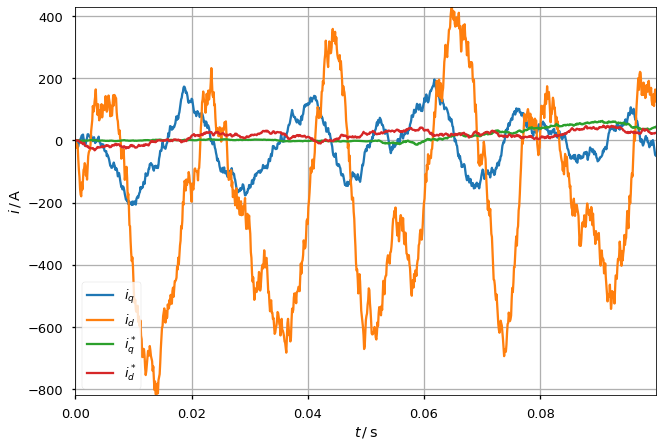

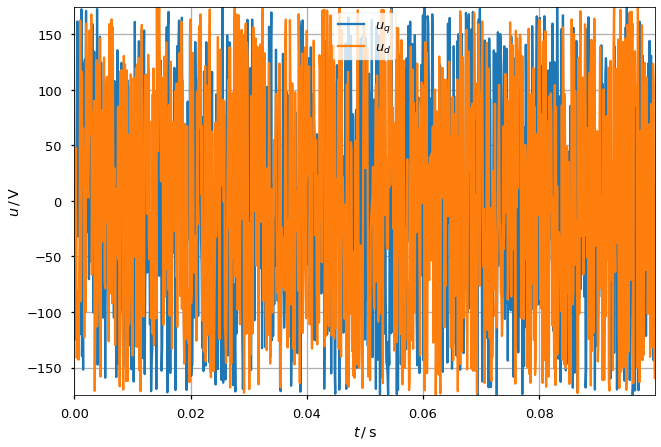

In [3]:
x = env.reset()
tau = env.env._physical_system.tau

simulation_time = 0.1 # seconds
nb_steps = int(simulation_time // tau)

X = []
U = []
T = []
t = 0
for i in tqdm(range(nb_steps)): 
    action = env.action_space.sample()
    X.append(x)
    U.append(action)
    T.append(t)
    x, reward, done, _ = env.step(action)
    
    t = t + tau
    
X = np.reshape(X, (-1, len(x)))
U = np.reshape(U, (-1, len(action)))

plt.plot(T, X[:, 0], label=r"$i_q$")
plt.plot(T, X[:, 1], label=r"$i_d$")
plt.plot(T, X[:, 2], label=r"$i_q^*$")
plt.plot(T, X[:, 3], label=r"$i_d^*$")
plt.xlabel(r'$t \, / \, \mathrm{s}$')
plt.ylabel(r'$i \, / \, \mathrm{A}$')
plt.autoscale(tight=True)
plt.legend()
plt.grid(True)
plt.show()

plt.plot(T, U[:, 0], label=r"$u_q$")
plt.plot(T, U[:, 1], label=r"$u_d$")
plt.xlabel(r'$t \, / \, \mathrm{s}$')
plt.ylabel(r'$u \, / \, \mathrm{V}$')
plt.autoscale(tight=True)
plt.legend()
plt.grid(True)
plt.show()

## Your Code

In [4]:
#### START YOUR SOLUTION HERE ####
#
# SOME INSPIRATION:
#
#
# FEYNMAN ALGORITHM
# 1. WRITE DOWN THE PROBLEM
# 2. THINK REAL HARD
# 3. WRITE DOWN THE SOLUTION

Besides highlighting the training progress in your evaluation, measure the performance of the resulting agent by calculating the mean and variance of the reward over the course of 50 validation episodes with a length of 1000 timesteps per episode. 

##### Much success!

In [5]:
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Flatten, Concatenate
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [6]:
class Exploration_noise:
    def __init__(self, mu, std_deviation, theta=0.15, dt=0.01, x_initial=None):
        self.theta = theta
        self.mu = mu
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape))
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mu)

In [7]:
class DDPGAgent:
    def __init__(self,environment):
        self.env = environment
        # Hyperparameters
        self.memory  = deque(maxlen=25000)
        self.gamma = 0.99 # Discount rate
        self.actor_learning_rate = 0.00001
        self.critic_learning_rate = 0.005
        self.batch_size = 96 # No of samples sampled from reply buffer at every step
        self.exploration_decay = 0.99995 # Decay standard deviation of noise to slowly stop exploring and start exploiting
        self.tau = self.env.env.physical_system.tau 
        self.upper_bound = self.env.action_space.high
        self.lower_bound = self.env.action_space.low
        
        # Initialise actor model and target actor model
        self.actor = self.set_actor_model()
        self.target_actor = self.set_actor_model()
        # set actor model and target actor model with same initial weights
        self.target_actor.set_weights(self.actor.get_weights())
        self.actor.summary()
        
        # Initialise critic model and target critic target model
        self.critic = self.set_critic_model()
        self.target_critic = self.set_critic_model()
        #set critic model and target critic target model with same initial weights
        self.target_critic.set_weights(self.critic.get_weights())
        self.critic.summary()
        
        # compile actor and critic models
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_learning_rate)
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_learning_rate)
    
    def set_actor_model(self):
        # actor(policy model) takes state as input and outputs the action to be taken
        actor = Sequential()
        actor.add(Flatten(input_shape=(1,) +self.env.observation_space.shape))
        actor.add(Dense(16, activation = 'relu'))
        actor.add(Dense(17, activation = 'relu'))
        actor.add(Dense(self.env.action_space.shape[0],kernel_initializer=tf.random_uniform_initializer(minval=-0.003, maxval=0.003),
                        activation='tanh',bias_initializer = tf.random_uniform_initializer(minval=-0.0003, maxval=0.0003),
                       kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) 
        actor.add(tf.keras.layers.Lambda(lambda x: x * 175)) # new output layer with actions in [-175,175]
        return actor
    
    def set_critic_model(self):
        # critic takes state,action as input and predicts vaue function
        action_input = Input(shape=(self.env.action_space.shape[0]))
        observation_input = Input(shape=(1,) + self.env.observation_space.shape)
        flattened_observation = Flatten()(observation_input)
        x = Concatenate()([flattened_observation,action_input])
        x = Dense(32, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        out = Dense(1, activation='linear')(x)
        critic = Model(inputs=(action_input, observation_input), outputs=out)  
        return critic
    

    def delibrate(self, obs):
        # wait till we have enough samples to sample from reply buffer
        if self.update < self.batch_size:
            return
        # sample batch_size number of entries from reply buffer randomly
        samples = random.sample(self.memory, self.batch_size)
        
        # Empty lists to later append respective seperated entries from each sample
        cur_state_list=[]
        action_list=[]
        reward_list=[]
        next_state_list=[]
        
        for i in range(len(samples)):
            current_state, action, reward, next_state, done = samples[i]
            cur_state_list.append(current_state)
            action_list.append(action)
            reward_list.append([reward])
            next_state_list.append(next_state)
       
        # converting lists to the way the model expects it's input to be in!
        reward_array= np.array(reward_list)
        next_state_array = np.array(next_state_list)
        action_array = np.array(action_list)
        current_state_array = np.array(cur_state_list)
        
        # Training Critic
        if not done:
            with tf.GradientTape(persistent = True) as tape:
                target_action_array = self.target_actor(next_state_array)
                # y = r + gamma * next Q value
                y = reward_array + self.gamma * self.target_critic([target_action_array,next_state_array])
                # current Q value
                critic_value = self.critic([action_array,current_state_array])
                # critic loss is [r + gamma * next Q value - current Q value]^2, i.e TD error
                critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value)) 
            critic_gradients = tape.gradient(critic_loss,self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_gradients,self.critic.trainable_variables))
            
        # Training Actor     
        if not done:
            with tf.GradientTape(persistent = True) as tape1:
                action = self.actor(current_state_array)
                critic_val = self.critic([action,current_state_array])
                # change in actor parameters affect critic value, i.e evaluation of actor's output using critic's output
                actor_loss = -tf.math.reduce_mean(critic_val) # negative since we want to maximise it
            actor_gradients = tape1.gradient(actor_loss,self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_gradients,self.actor.trainable_variables))
        
    # Soft update of target network parameters at each step        
    @tf.function
    def update_target(self,target_weights, weights ,tau=0.002):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * tau + a * (1 - tau))
            
    # Function to decide what action to take each step    
    def decide(self,state,std_dev):
        # Initialise noise object
        ou_noise = Exploration_noise(mu=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
        action_samples = tf.squeeze(self.actor.predict(np.array([state]))[0])
        noise = ou_noise()
        action_samples = action_samples.numpy()
        action_samples += noise * 0.1 * self.upper_bound[0] # 10% action_upper_bound(175) is used for training. 
        # action is in [-175, 175]
        action = np.clip(action_samples, self.lower_bound[0], self.upper_bound[0])
        return action
    
    
    # add observations to memory
    def memory_update(self,current_state,action , reward, next_state, done):
        self.memory.append((current_state,action , reward, next_state, done))
        
    def train(self,sim_time,max_episode_len,visualise=False):
        simulation_time = sim_time # seconds
        nb_steps =int(simulation_time // self.tau)
        max_episode_length = max_episode_len 
        nb_episodes = int(nb_steps//max_episode_length) + 1
        log = {'cum_rew': []} 
        std_dev = 0.3 # standard deviation of noise for exploration
        self.update = 0
        
        for i in tqdm(range(nb_episodes)):
            # collect states and action to print 
            X=[]
            U = []
            T=[]
            k = 0
            t=0
            cum_rew = 0
            # Reset every episode
            cur_state = self.env.reset()
            cur_state = cur_state.reshape((1, self.env.observation_space.shape[0]))
            done = False
            while not done:
                # get action combined with noise for exploration
                action = self.decide(cur_state,std_dev)
                # perform action on environment and obtain S' and R
                next_state, reward, done, _ = self.env.step(action)
                done = done or k == (max_episode_length - 1)  # force done after max_episodes
                next_state = next_state.reshape((1, self.env.observation_space.shape[0]))
                # adding (S,A,R,S') to reply buffer
                self.memory_update(cur_state,action,reward,next_state, done)
                # Train actor critic
                self.delibrate(next_state)
                
                if visualise:
                    X.append(cur_state[0])
                    U.append(action)
                    T.append(t)
                    
                cur_state = next_state 
                #soft update target model to be similar to its respective model by a certain factor 'tau'
                self.update_target(self.target_actor.variables, self.actor.variables)
                self.update_target(self.target_critic.variables, self.critic.variables)
                t = t + self.tau
                self.update += 1
                k += 1
                cum_rew += reward
                std_dev = std_dev * self.exploration_decay # Exploration decay at each step
            print('Reward of episode ' + str(i) + '  is ' + str(cum_rew))
            log['cum_rew'].append(cum_rew)
            
            if visualise:
                X = np.reshape(X, (-1, len(cur_state[0])))
                U = np.reshape(U, (-1, len(action)))
                
                # Plot states
                plt.plot(T, X[:, 0], label=r"$i_q$")
                plt.plot(T, X[:, 1], label=r"$i_d$")
                plt.plot(T, X[:, 2], label=r"$i_q^*$")
                plt.plot(T, X[:, 3], label=r"$i_d^*$")
                plt.xlabel(r'$t \, / \, \mathrm{s}$')
                plt.ylabel(r'$i \, / \, \mathrm{A}$')
                plt.autoscale(tight=True)
                plt.legend()
                plt.grid(True)
                plt.show()
                
                # Plot actions
                plt.plot(T, U[:, 0], label=r"$u_q$")
                plt.plot(T, U[:, 1], label=r"$u_d$")
                plt.xlabel(r'$t \, / \, \mathrm{s}$')
                plt.ylabel(r'$u \, / \, \mathrm{V}$')
                plt.autoscale(tight=True)
                plt.legend()
                plt.grid(True)
                plt.show()
        return log
                
    def test(self,n_episodes=50, max_episode_len=1000, Visualise = True):
        log = {'cum_rew': []}
        for ep in tqdm(range(n_episodes)):
            X=[]
            U=[]
            T=[]
            state = self.env.reset()
            state = state.reshape((1, self.env.observation_space.shape[0]))
            k = 0
            t=0
            cum_rew = 0
            done = False
            while not done:
                # get predictions from trained actor model
                action = self.actor.predict(np.array([state]))[0]
                next_state, reward, done, _ = self.env.step(action)
                next_state = next_state.reshape((1, self.env.observation_space.shape[0]))
                done = done or k == (max_episode_len - 1)  # force done after max_episodes
                X.append(state)
                U.append(action)
                T.append(t)
                k+=1
                t = t + self.tau
                cum_rew += reward
                state = next_state
            log['cum_rew'].append(cum_rew)
            print(cum_rew)
            if Visualise:
                # Plot states
                X = np.reshape(X, (-1, len(state[0])))
                U = np.reshape(U, (-1, len(action)))
                plt.plot(T, X[:, 0], label=r"$i_q$")
                plt.plot(T, X[:, 1], label=r"$i_d$")
                plt.plot(T, X[:, 2], label=r"$i_q^*$")
                plt.plot(T, X[:, 3], label=r"$i_d^*$")
                plt.xlabel(r'$t \, / \, \mathrm{s}$')
                plt.ylabel(r'$i \, / \, \mathrm{A}$')
                plt.autoscale(tight=True)
                plt.legend()
                plt.grid(True)
                plt.show()

                # Plot actions
                plt.plot(T, U[:, 0], label=r"$u_q$")
                plt.plot(T, U[:, 1], label=r"$u_d$")
                plt.xlabel(r'$t \, / \, \mathrm{s}$')
                plt.ylabel(r'$u \, / \, \mathrm{V}$')
                plt.autoscale(tight=True)
                plt.legend()
                plt.grid(True)
                plt.show()
        print(f'tested for {ep+1} episodes')
        print('Mean is',np.array(log['cum_rew']).mean()),print('variance is' , np.array(log['cum_rew']).var())
        return log

In [8]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

In [9]:
agent = DDPGAgent(env)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 17)                289       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 36        
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (typ

In [10]:
# Training for 20 episodes of 5000 steps each
tr_log = agent.train(sim_time = 10, max_episode_len=5000,visualise=False )
# note the the training visualisation is turned off intentionally to avoid excess time consumption, however it can be verified by setting 'visualise = True' above

Reward of episode 0  is -12738.22388627893
Reward of episode 1  is -43223.446877619856
Reward of episode 2  is -26238.695034078377
Reward of episode 3  is -5000.685439300723
Reward of episode 4  is -8164.42877928856
Reward of episode 5  is -5408.623016265422
Reward of episode 6  is -2694.546927482494
Reward of episode 7  is -2257.1824103849085
Reward of episode 8  is -9562.54909477916
Reward of episode 9  is -2936.5028288704334
Reward of episode 10  is -134.6465253171435
Reward of episode 11  is -3391.3449548418384
Reward of episode 12  is -542.9535495828409
Reward of episode 13  is -1012.9797762514247
Reward of episode 14  is -1003.2493875182735
Reward of episode 15  is -262.95063417236787
Reward of episode 16  is -1371.0426658263925
Reward of episode 17  is -1849.331978199875
Reward of episode 18  is -1760.572209813229
Reward of episode 19  is -2342.0645268839826



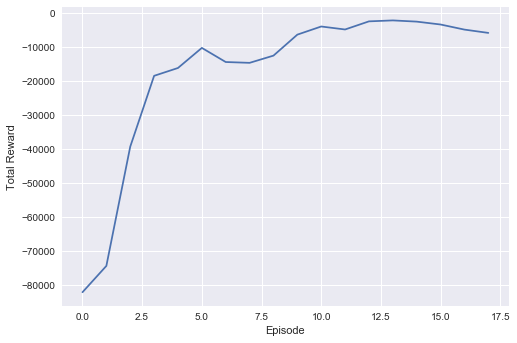

In [11]:
#make simple moving average over 3 episodes (smoothing) and plot
SMA_rewards = np.convolve(tr_log['cum_rew'], np.ones((3,))/1, mode='valid')
#Plot learning curve
plt.style.use('seaborn')
plt.plot(SMA_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

-137.2509690744735


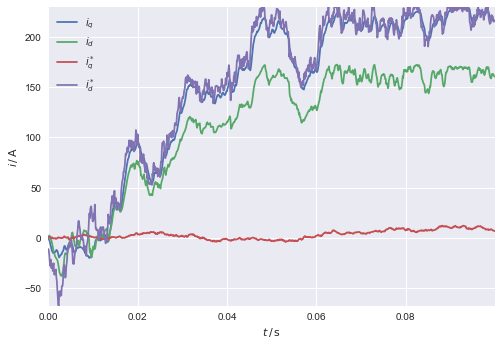

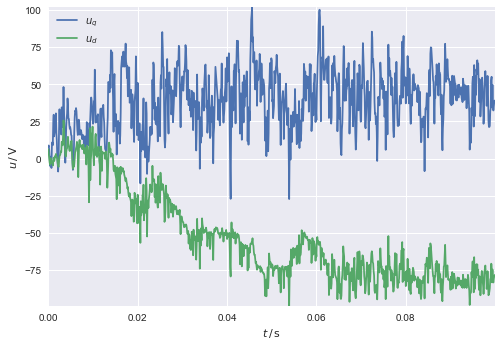

-2.562731006739875


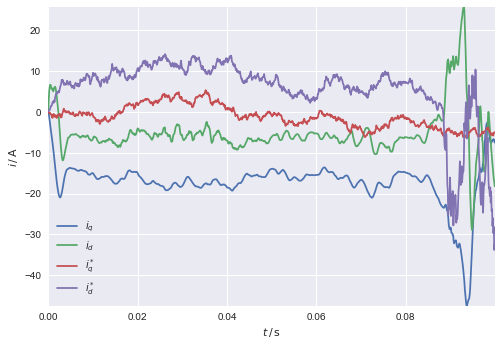

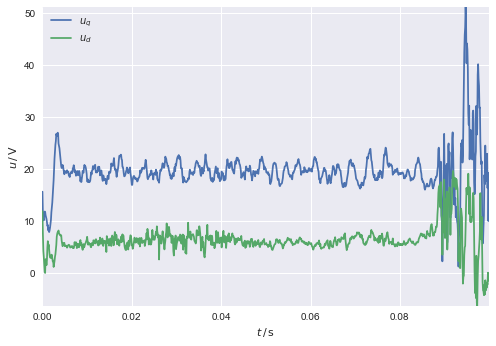

-45.18789049977934


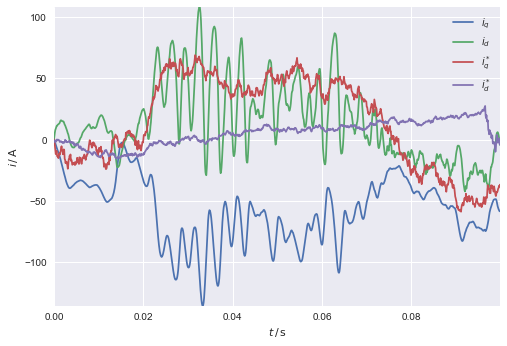

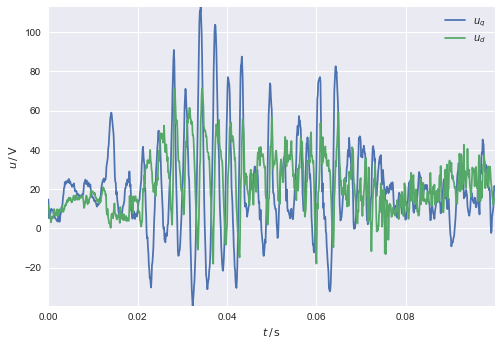

-35.41594529607595


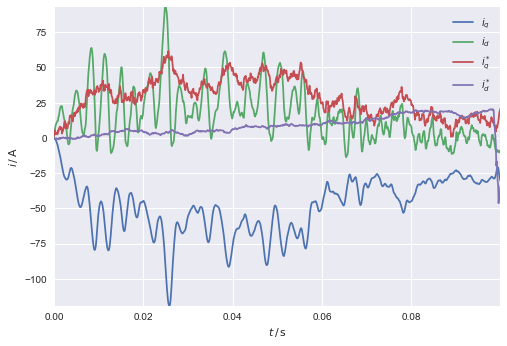

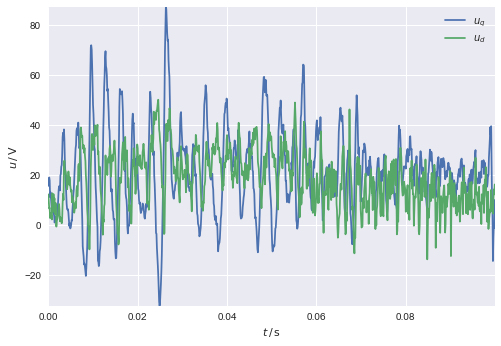

-13.555566088064365


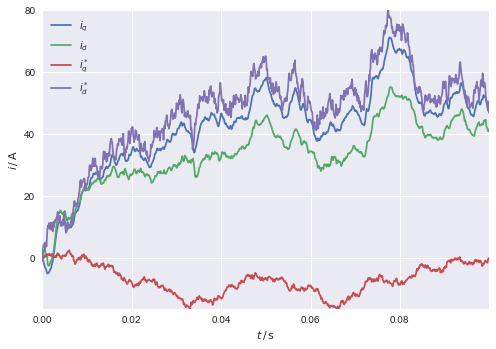

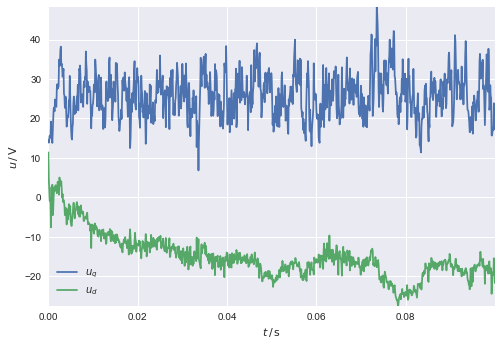

-118.1811134547796


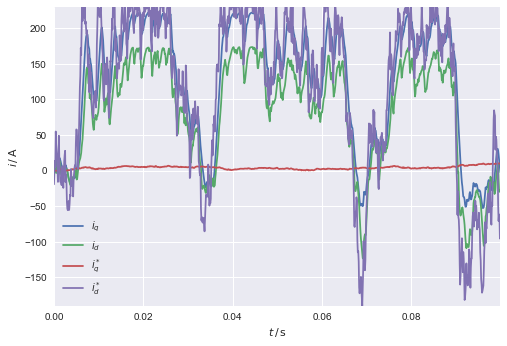

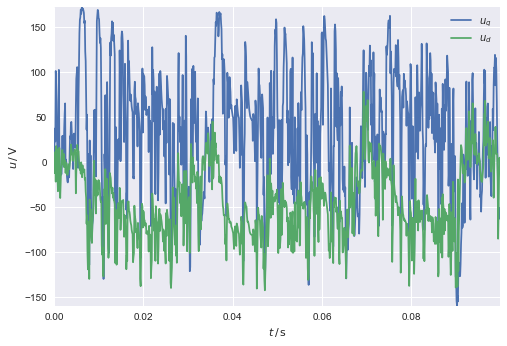

-188.23526492767112


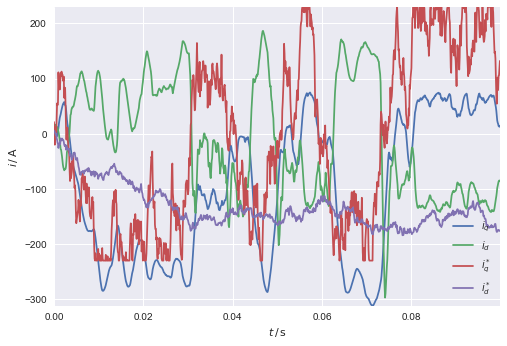

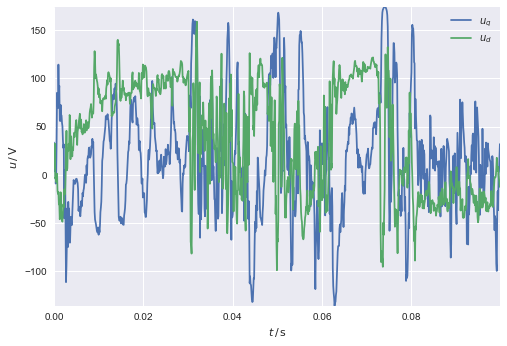

-34.24816451045821


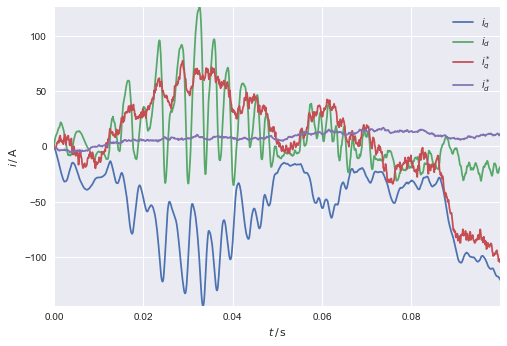

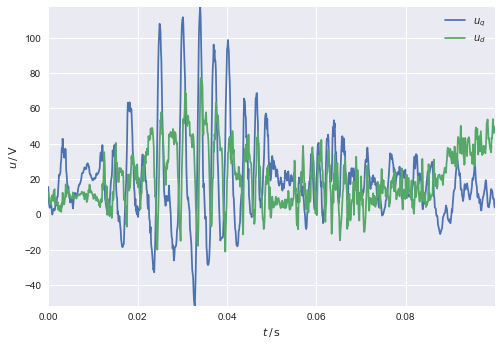

-27.805984657363503


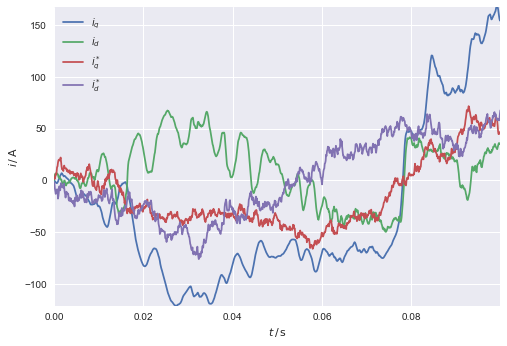

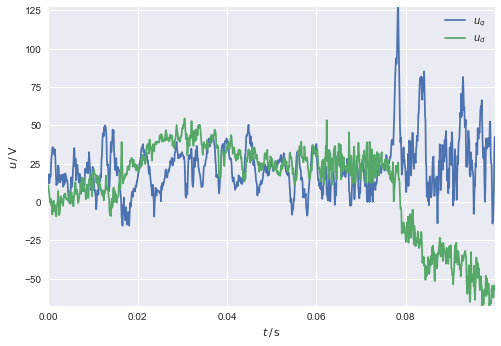

-1.8715827779942058


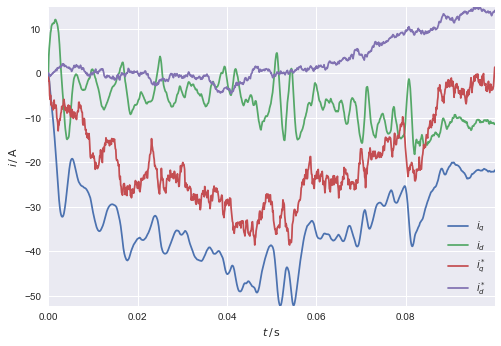

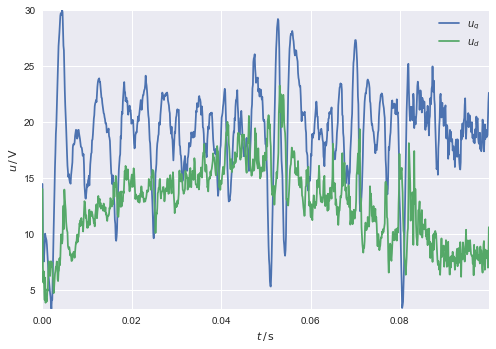

-10.874163935970104


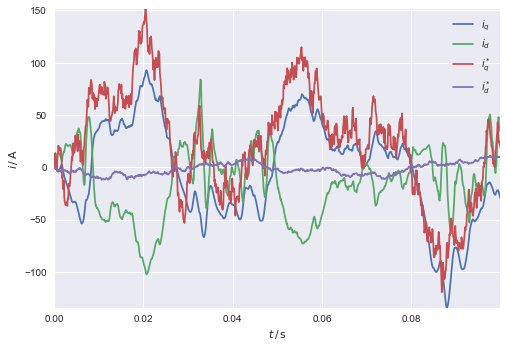

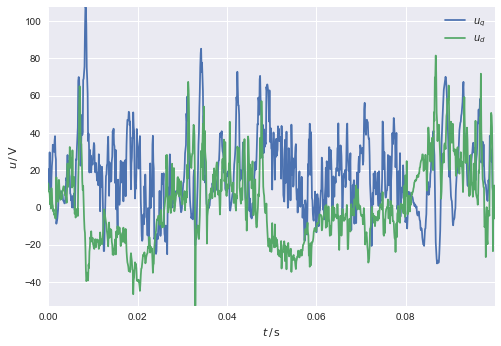

-88.02789243851899


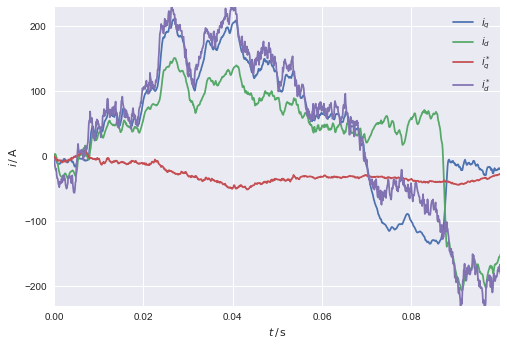

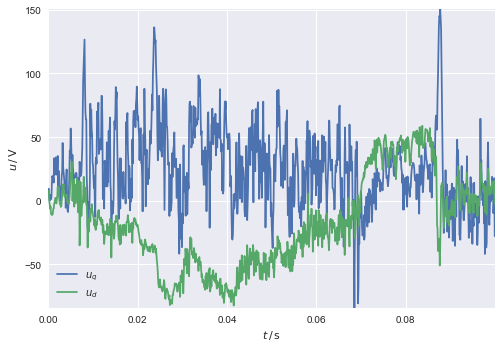

-341.6338466803835


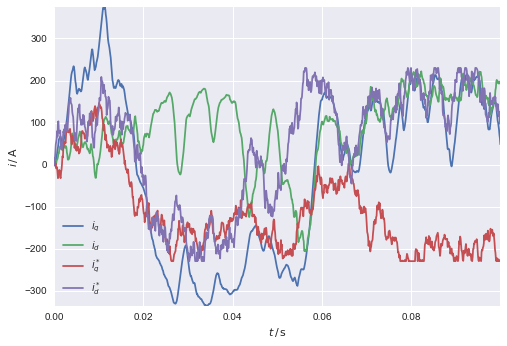

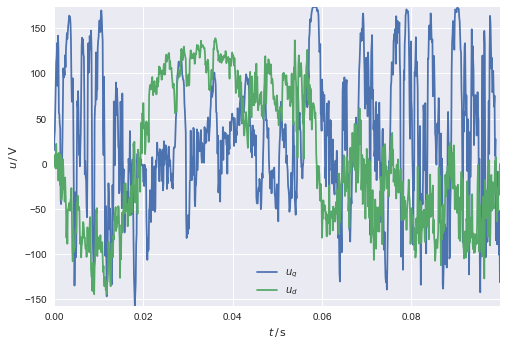

-30.443707470406828


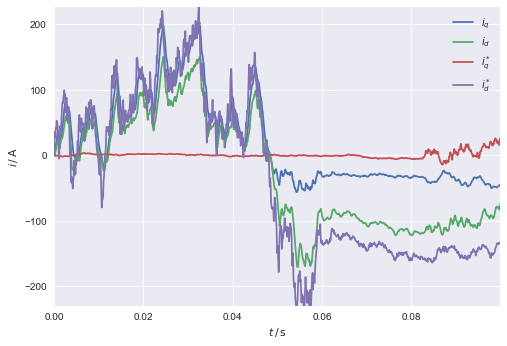

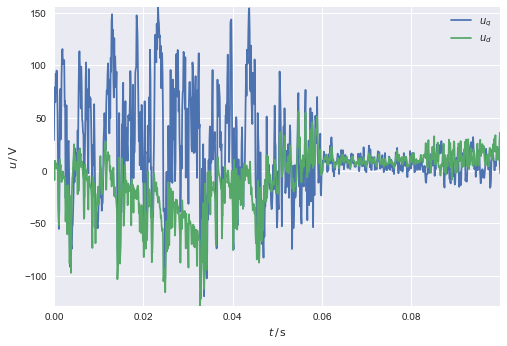

-205.5549788001395


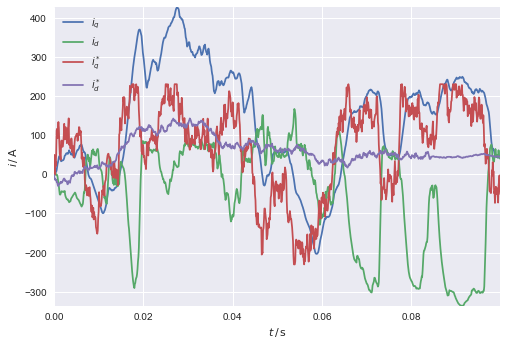

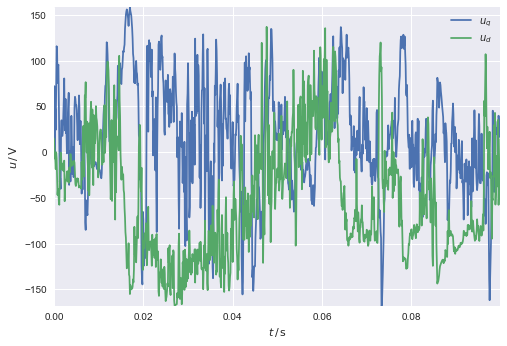

-21.096464404045683


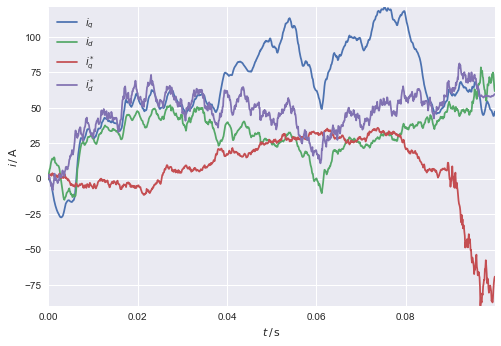

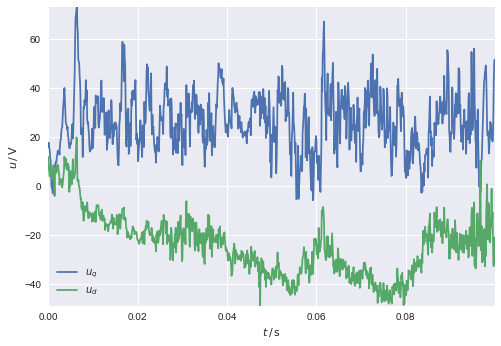

-272.2901048836829


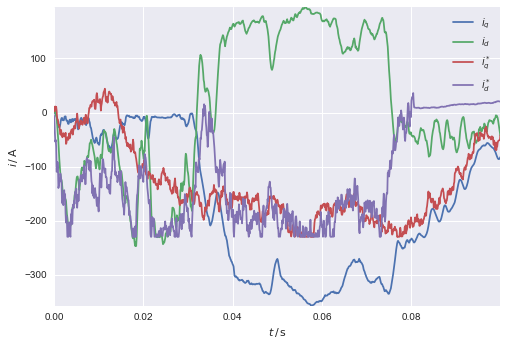

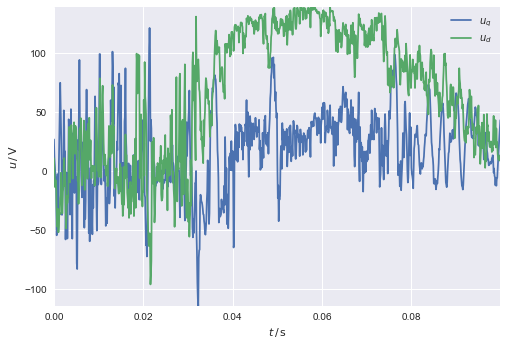

-11.199114365003428


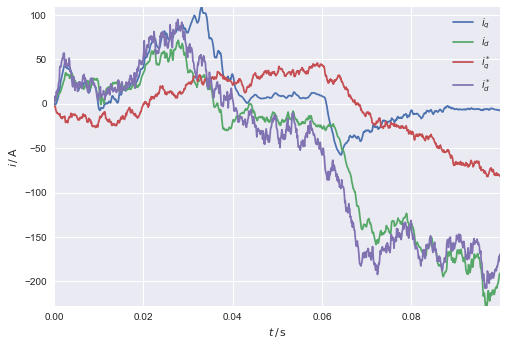

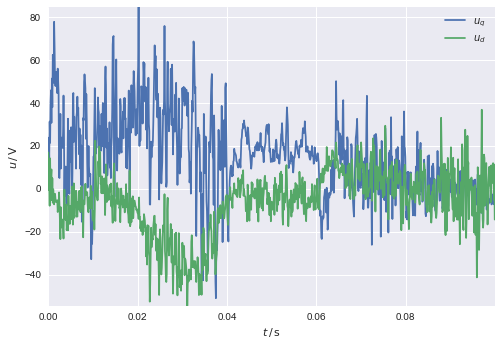

-8.125453379069231


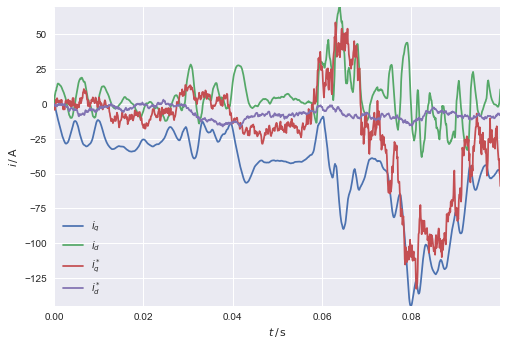

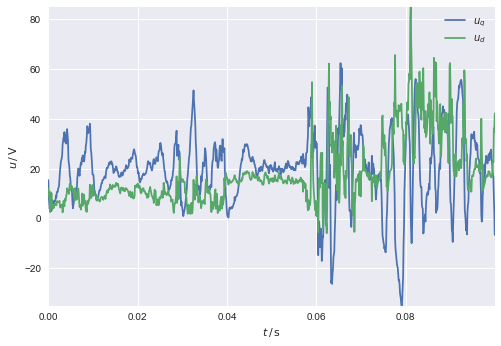

-193.64009984682755


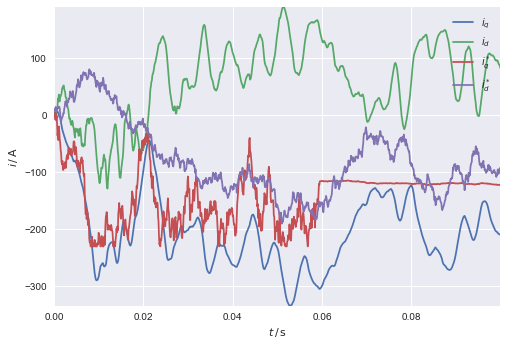

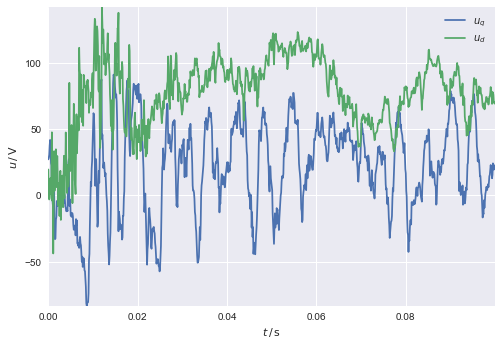

-31.464469625525844


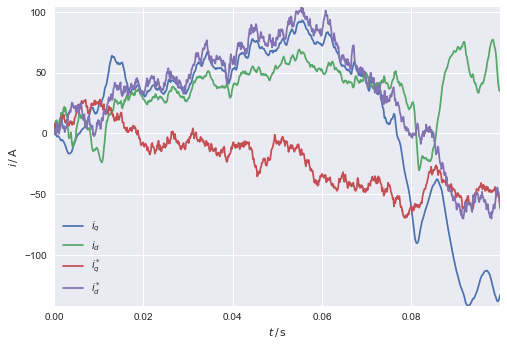

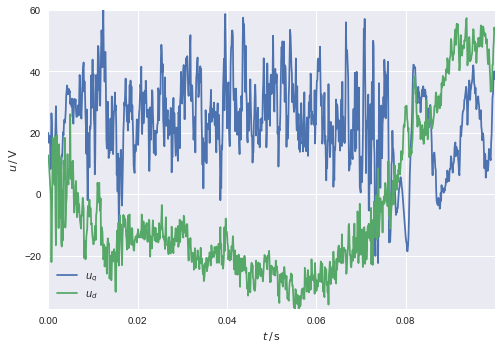

-17.627398699547953


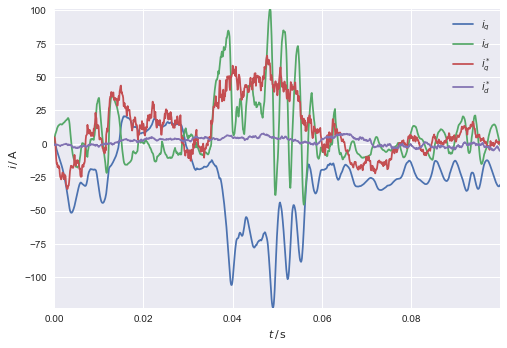

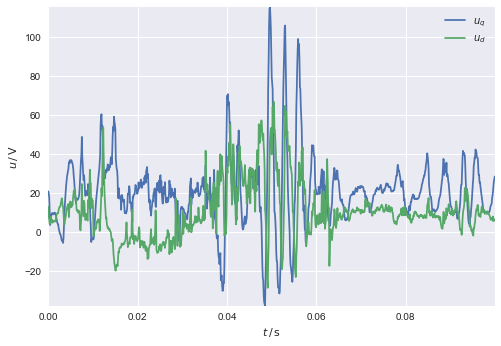

-70.1674528959116


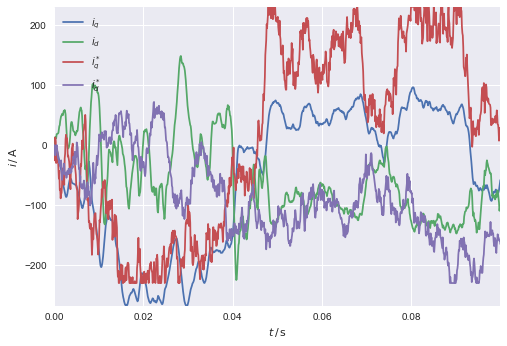

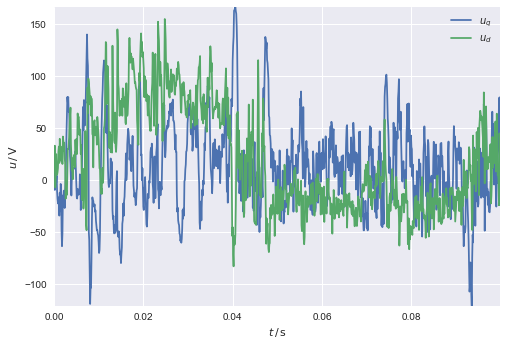

-79.68830422674439


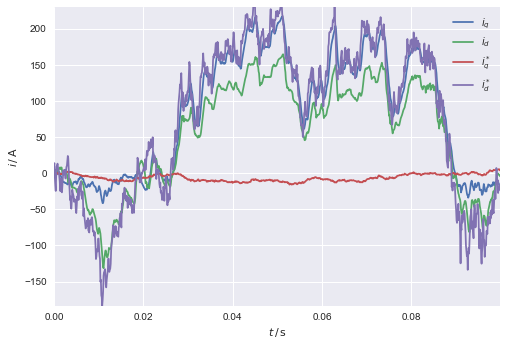

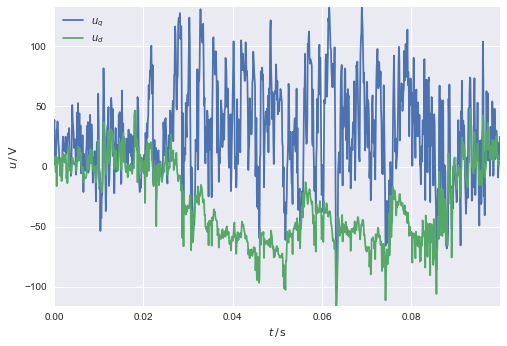

-4.533091453996444


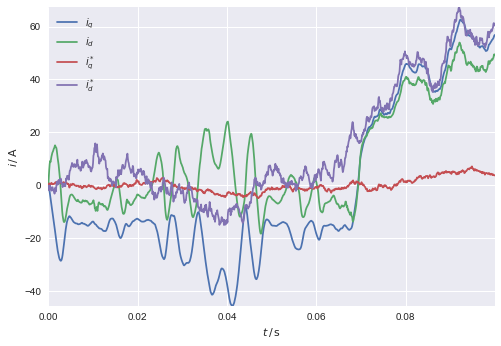

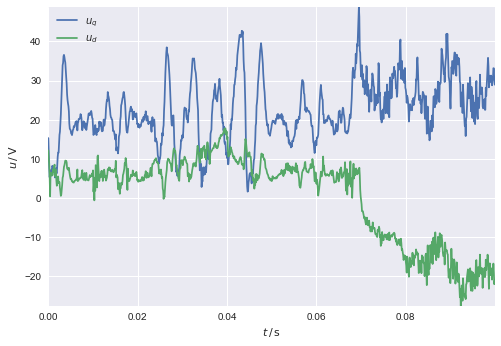

-15.541426981830723


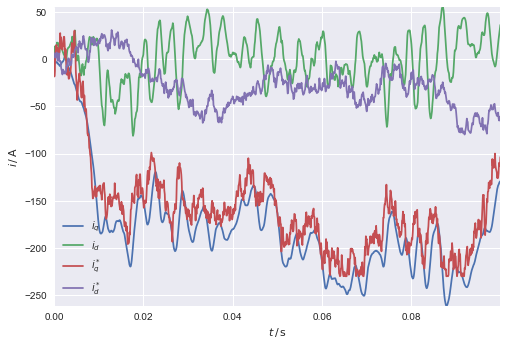

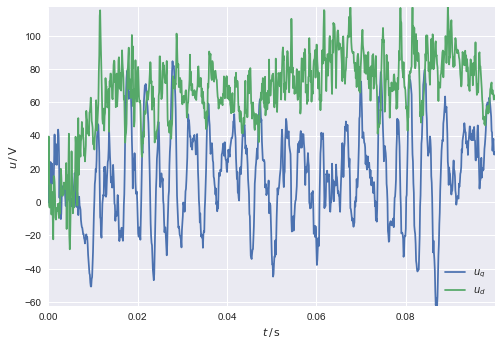

-1.712092426518859


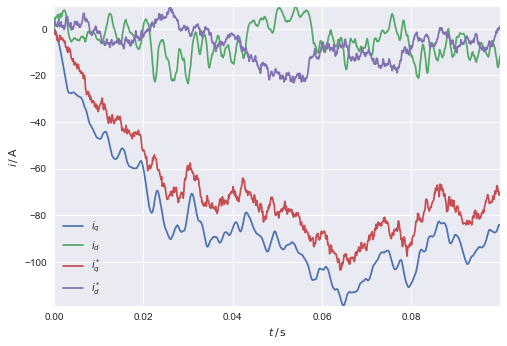

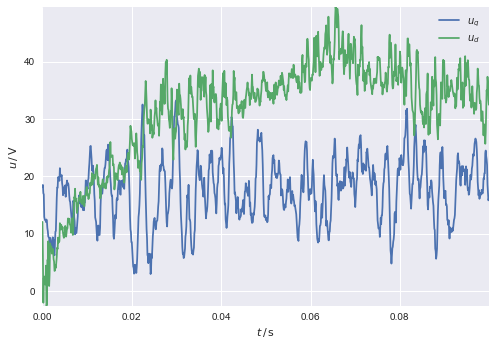

-67.24691514981299


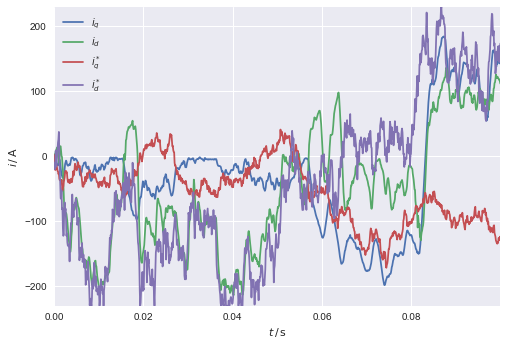

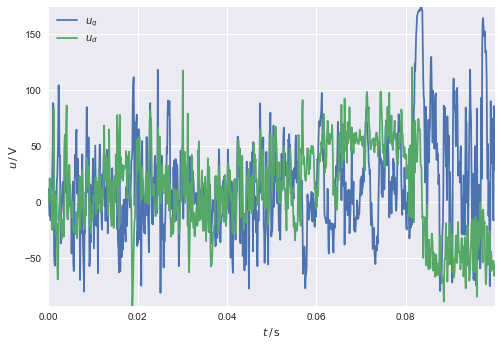

-40.02506325508903


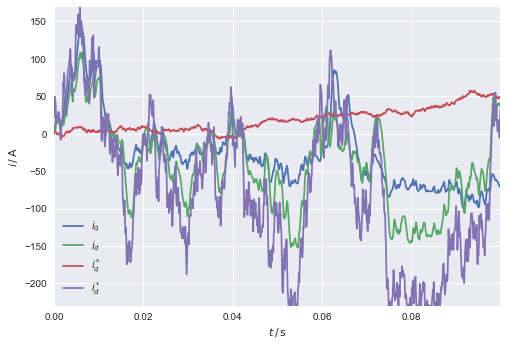

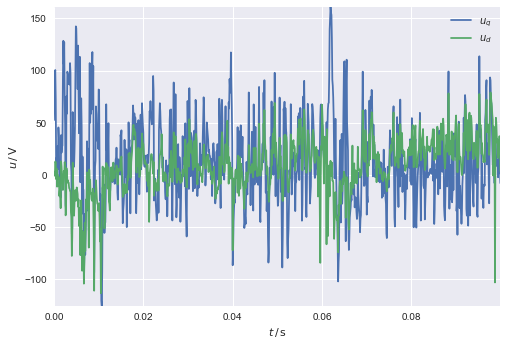

-19.90556310693507


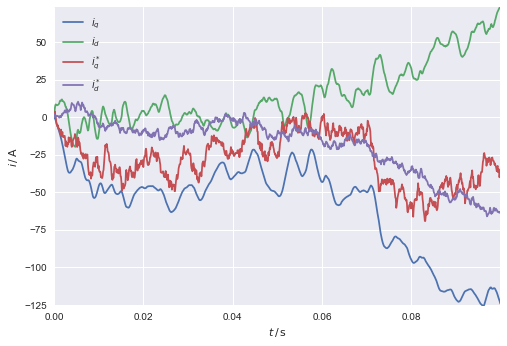

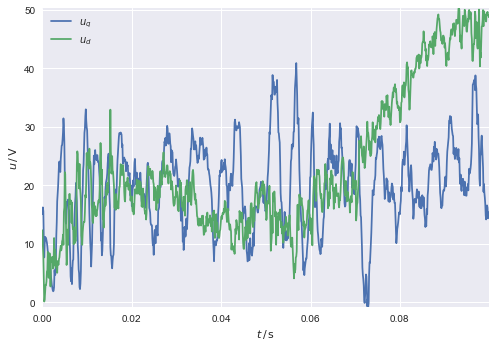

-7.225393817939966


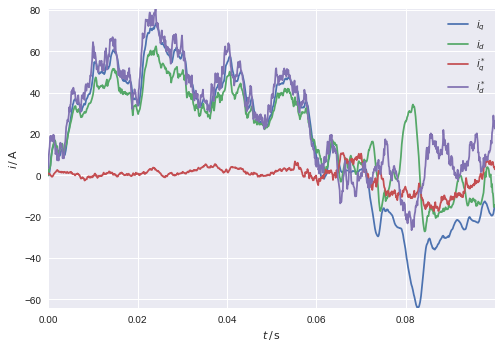

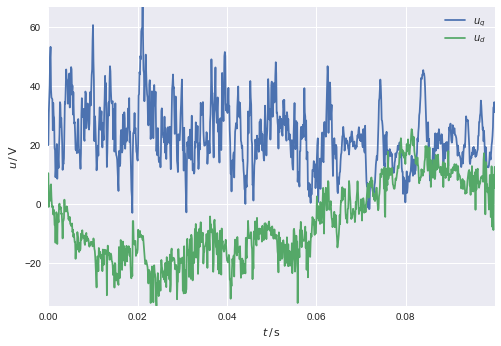

-7.527844284404135


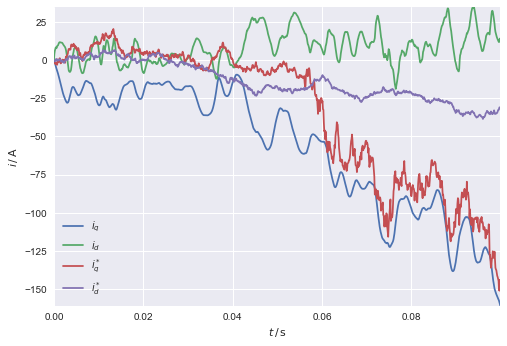

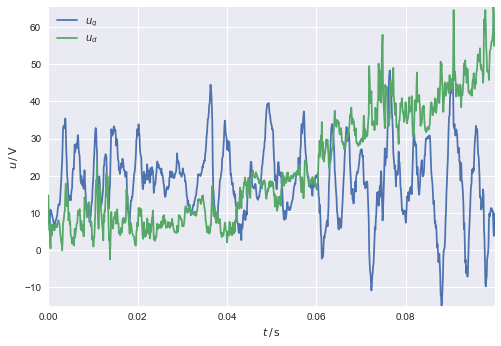

-5.669262759683058


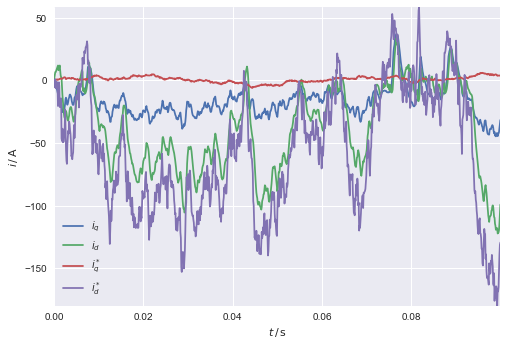

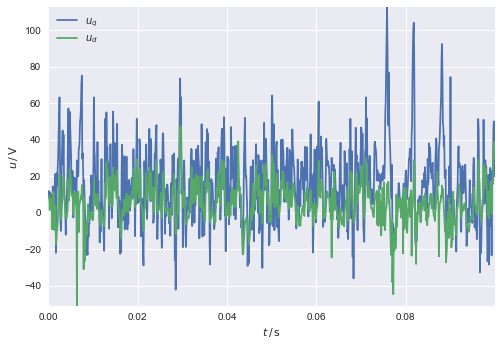

-192.48677892464883


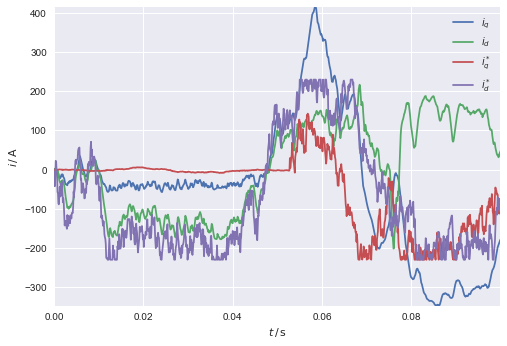

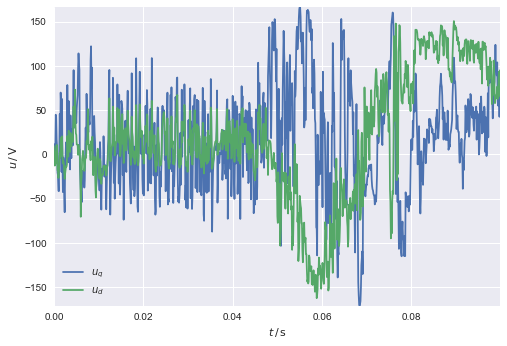

-54.12365901983399


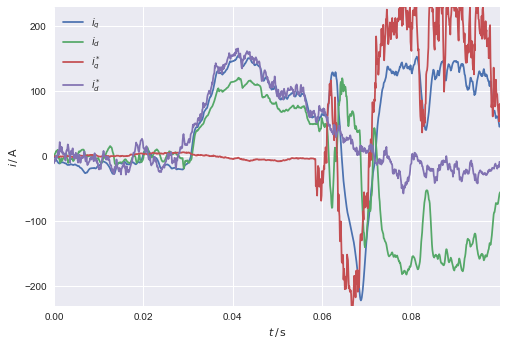

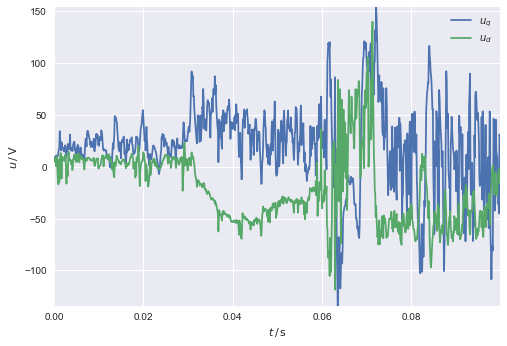

-13.43456842044618


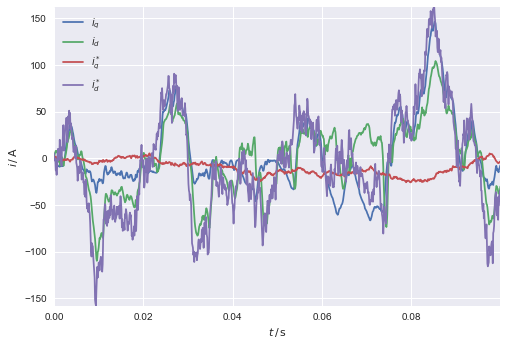

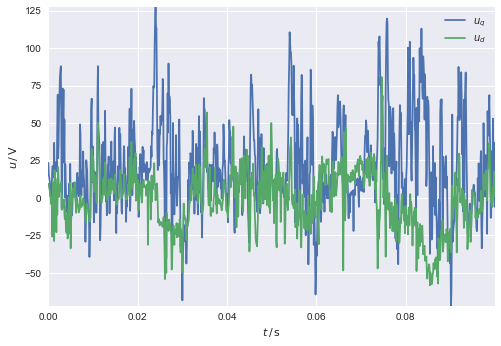

-53.20915527950398


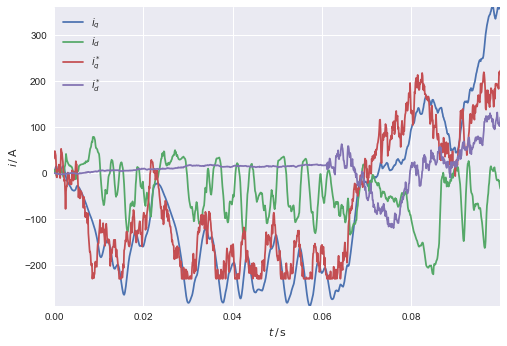

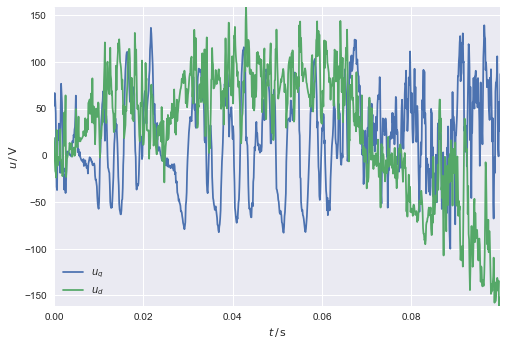

-12.164781103808139


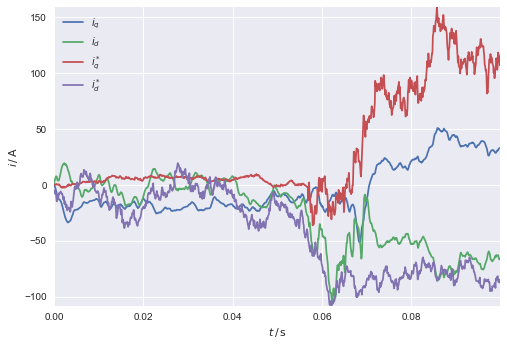

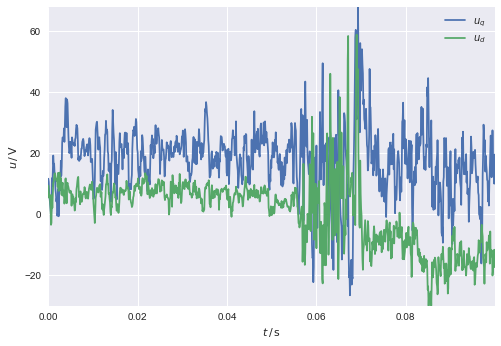

-16.364136380598662


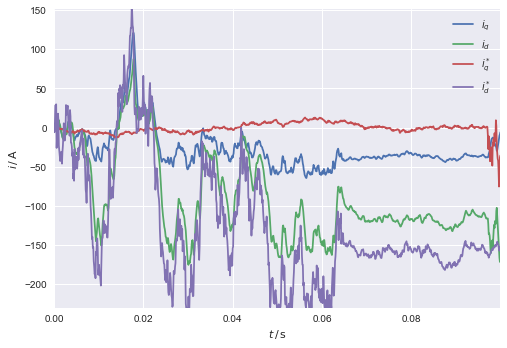

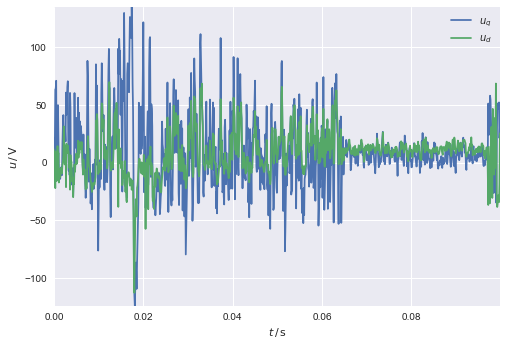

-79.64390741994538


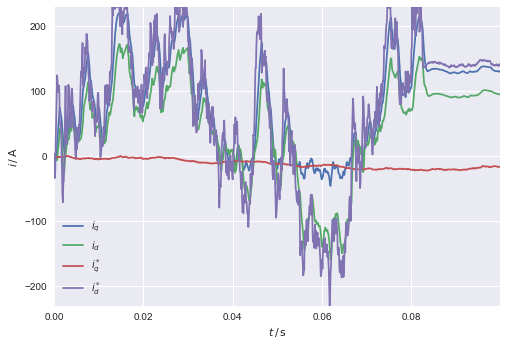

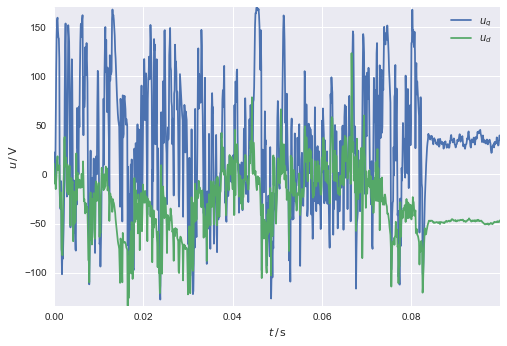

-104.90199135876045


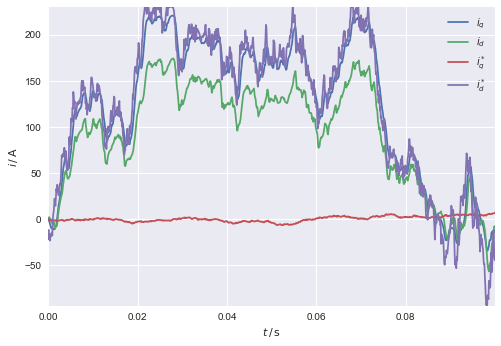

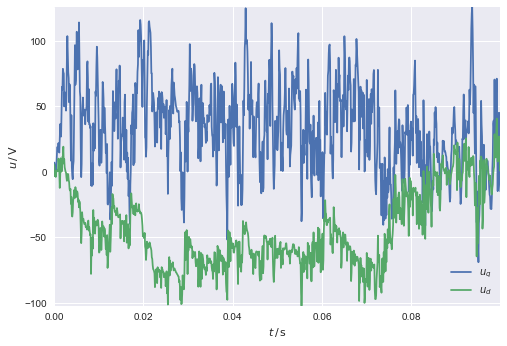

-31.66552511226535


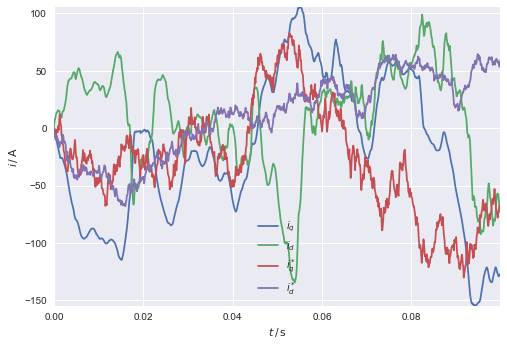

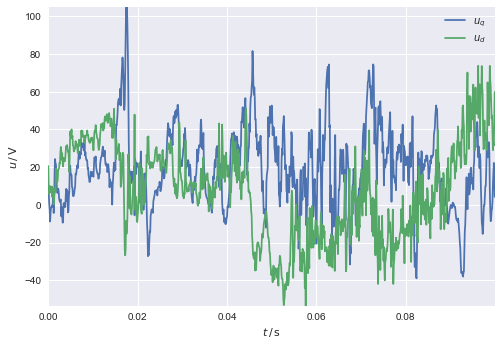

-48.94458279719796


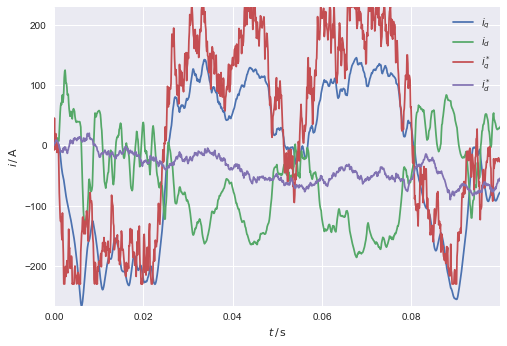

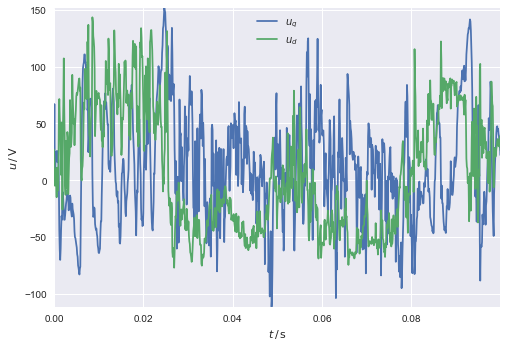

-47.35027493072067


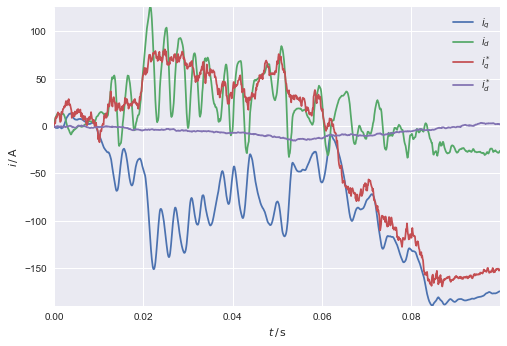

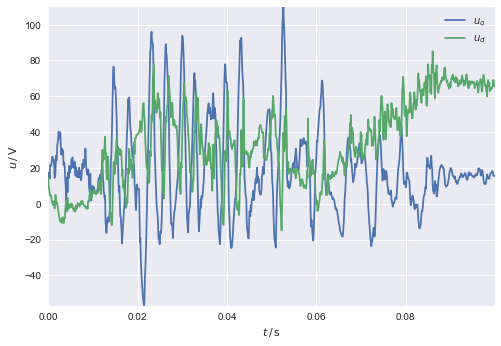

-66.816226723435


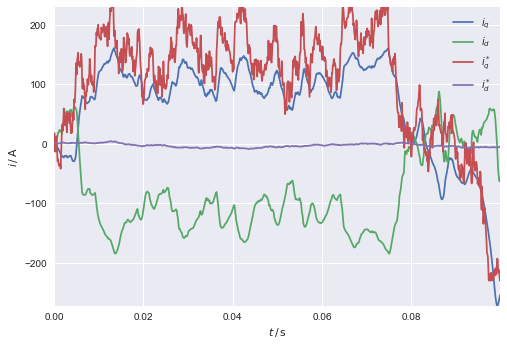

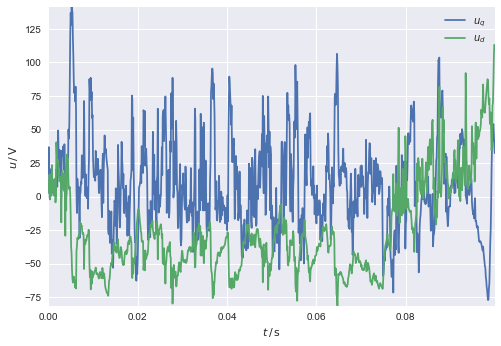

-241.60346476330224


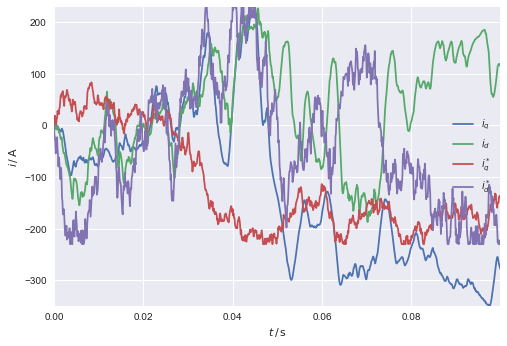

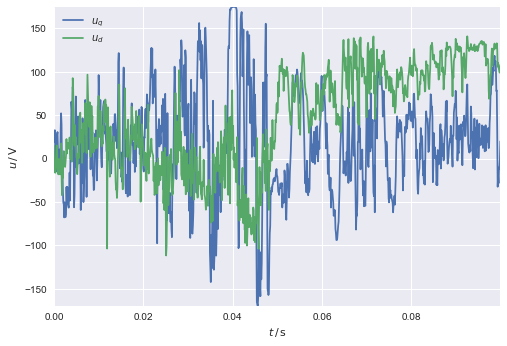

-91.00253153424507


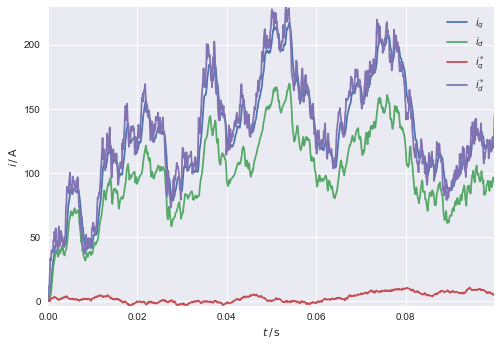

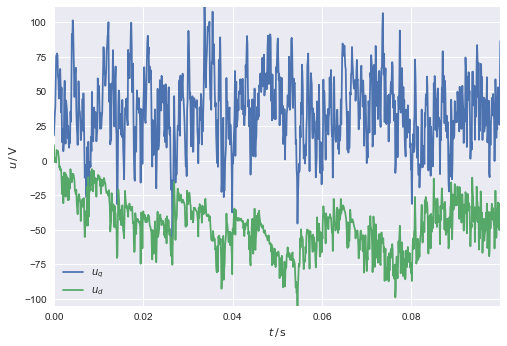

-10.61278152166287


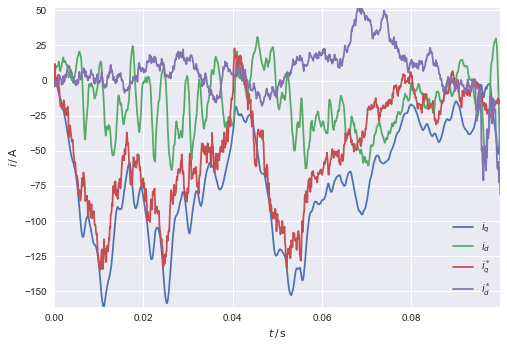

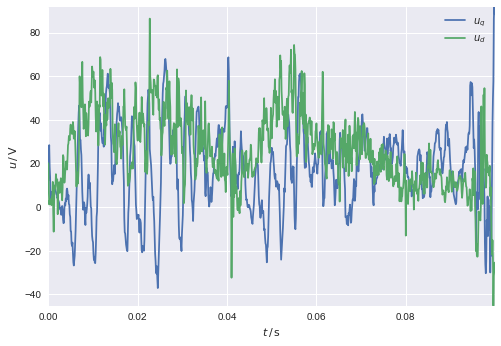

-110.69308973238428


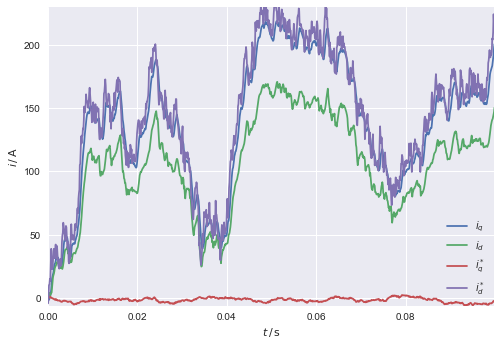

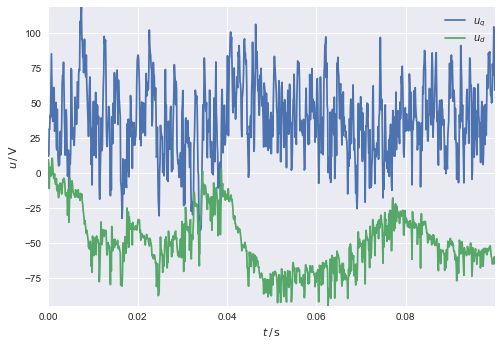

-22.993544198511174


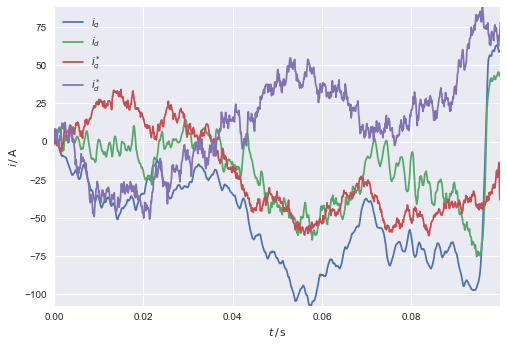

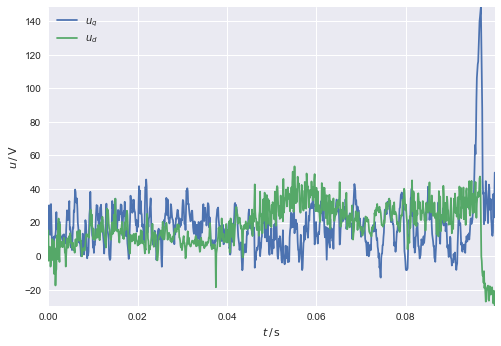


tested for 50 episodes
Mean is -67.07092632805316
variance is 5973.84775479021


In [12]:
# Testing for 50 episodes with max episode length of 1000 steps
test_log = agent.test(n_episodes=50,max_episode_len=1000) 

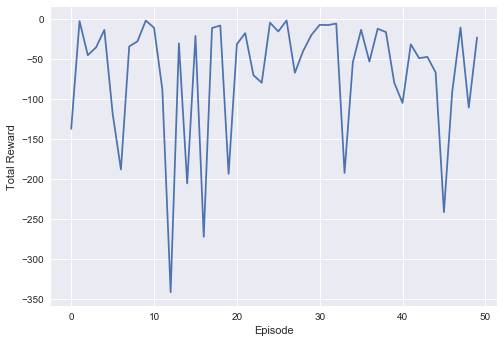

In [13]:
#make simple moving average over 5 episodes (smoothing) and plot
SMA_rewards = np.convolve(test_log['cum_rew'], np.ones((1,))/1, mode='valid')
#Plot learning curve
plt.style.use('seaborn')
plt.plot(SMA_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

-1116.0769111469986


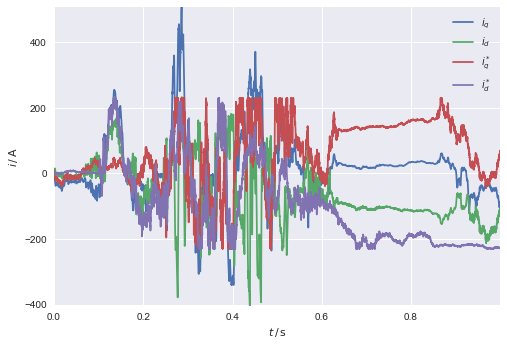

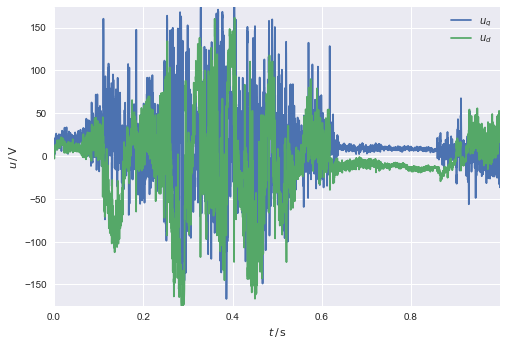


tested for 1 episodes
Mean is -1116.0769111469986
variance is 0.0


In [16]:
# Testing for a single episodes with large episode length to verify testing
test_log = agent.test(n_episodes=1,max_episode_len=10000) 